<a href="https://colab.research.google.com/github/SouvikUMD/Leaf-Disease-Prediction/blob/main/fpgasnnmodels_snnsimulation_weightsandconnections_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

This is combined code of the software of FPGA-friendly SNN models inspired by
the following link here [1]. The following code below follows the steps shown in [1]. First the network is simulated to get the approximate integer weights.
Next, the weights are extracted from the network and converted into 16 bit hex values. Finally, the original weights are tested with the original test data and the classification accuracy is evaluated. PyTorch and BindsNET packages are utilized below. New Features add to this version are hidden neuron connections and outputs which will be used for the FPGA board. For this notebook, the network is simulated for integer weights and the weights are extracted for connections and converted into 16-bit hex values.

[1] https://github.com/oshears/fpga_snn_models/tree/main.

# Set Up Environment

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

## Install Libraries

In [5]:
#!pip install bindsnet

In [6]:
!ls fpga_snn_models/models/*.py

fpga_snn_models/models/diehl_cook_snn.py  fpga_snn_models/models/__init__.py
fpga_snn_models/models/if_snn.py


In [7]:
!cat 'fpga_snn_models/models'

cat: fpga_snn_models/models: Is a directory


In [8]:
import sys
path_name = '/content/drive/My Drive/Colab Notebooks/fpga_snn_models/'
sys.path.append('fpga_snn_models/models')
os.chdir(f'{path_name}models')

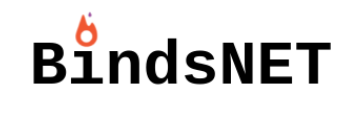

BindsNET is built on top of PyTorch platform. It is used for the simulation of SNNs and is geared towards machine learning and reinforcement learning. The BindsNet installation taken from [2]. Documentation Explanations for BindsNET is shown in [3].

[2] https://github.com/BindsNET/bindsnet.

[3] https://bindsnet-docs.readthedocs.io/

In [9]:
!pip install git+https://github.com/BindsNET/bindsnet.git

  Cloning https://github.com/BindsNET/bindsnet.git to /tmp/pip-req-build-j82b4w1u
  Running command git clone --filter=blob:none --quiet https://github.com/BindsNET/bindsnet.git /tmp/pip-req-build-j82b4w1u
  Resolved https://github.com/BindsNET/bindsnet.git to commit 0956fa8e029ef5e1e7257cb43ea2210a7260ce51
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.5 MB/s eta 0

In [10]:
# import numpy
import numpy as np

# import modules from pytorch
import torch
from torchvision import transforms

# import local modules
from diehl_cook_snn import DiehlAndCookNetwork16,DiehlAndCookNetwork32
from if_snn import IFNetwork16,IFNetwork32

# miscellaneous imports
import argparse

import cv2
from google.colab.patches import cv2_imshow
from PIL import Image # PIL is the Python Imaging Library
import random

In [11]:
# import modules from bindsnet
from bindsnet.datasets import MNIST, DataLoader, CIFAR10
from bindsnet.encoding import PoissonEncoder,BernoulliEncoder,RankOrderEncoder
from bindsnet.evaluation import all_activity,proportion_weighting,assign_labels
from bindsnet.network.monitors import Monitor
from bindsnet.network import load

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Variable Setup.

In [12]:
# create an argument parser to interpret command line arguments
parser = argparse.ArgumentParser()

# --encoding specifies the type of encoding (Poisson, Bernoulli or RankOrder)
parser.add_argument("--encoding", type=str, default="Poisson")
#parser.add_argument("--encoding", type=str, default="Bernoulli")
#parser.add_argument("--encoding", type=str, default="RankOrder")
parser.add_argument("--weight_size", type=int, default=32)
parser.add_argument("--neuron_type", type=str, default="IF")
#parser.add_argument("--neuron_type", type=str, default="diehlAndCook")
parser.add_argument("--batch_size", type=int, default=64)

# parse the arguments
#args = parser.parse_args()
args, unknown = parser.parse_known_args()


# declare global variables

# n_neurons specifies the number of neurons per layer
n_neurons = 1

# batch_size specifies the number of training samples to collect weight changes
# from before updating the weights.
batch_size = args.batch_size
print(f"Batch Size: {batch_size}")

# n_train specifies the number of training samples
#n_train = 60000
#n_train = 56000
#n_train = 49000
n_train = 5600

# n_test specifies the number of testing samples
#n_test = 10000
#n_test = 14000
#n_test = 21000
n_test = 1400

# update_steps specifies the number of batches to process before reporting
# an update.
update_steps = 10

# time specifies the simulation time of the SNN
time = 100

# dt specifies the timestep size for the simulation time
dt = 1

# intensity specifies the maximum intensity of the input data
intensity = 128

# gpu setting
gpu = torch.cuda.is_available()
print(f"GPU: {gpu}")

# Update_interval specifies the number of samples processed before updating
# accuracy estimations.
update_interval = update_steps * batch_size

# Setup CUDA
device = torch.device("cuda" if torch.cuda.is_available() and gpu else "cpu")

# Determine number of worker threads to load data.
n_workers = 0
# if n_workers == -1:
#     n_workers = gpu * 4 * torch.cuda.device_count()

# Report the selected encoding scheme, neural model and learning technique.
print("Encoding Scheme:",args.encoding)

# Assign a value to the encoder based on the input argument.
encoder = None
if args.encoding == "Poisson":
    encoder = PoissonEncoder(time=time,dt=dt)
if args.encoding == "Bernoulli":
    encoder = BernoulliEncoder(time=time,dt=dt)
if args.encoding == "RankOrder":
    encoder = RankOrderEncoder(time=time,dt=dt)

# Build network based on the input argument.
print(f"Neuron Model: {args.neuron_type}")
print(f"Weight Size: {args.weight_size}")

# Set up dimensions and pixel size.
dim = 28
pixel_size = 1

neuron_type = ""
if args.neuron_type == "IF":
    neuron_type = "if"
    if args.weight_size == 16:
        network = IFNetwork16(n_inpt=dim**2,
                              inpt_shape=(pixel_size, dim, dim), batch_size=128,
                              n_neurons=n_neurons)
    elif args.weight_size == 32:
        network = IFNetwork32(n_inpt=pixel_size*dim**2,
                              inpt_shape=(pixel_size, dim, dim), batch_size=128,
                              n_neurons=n_neurons)
else:
    neuron_type = "diehlAndCook"
    if args.weight_size == 16:
      network = DiehlAndCookNetwork16(n_inpt=pixel_size*dim**2,
                                      inpt_shape=(pixel_size, dim, dim),
                                      batch_size=128,
                                      n_neurons=n_neurons)
    elif args.weight_size == 32:
        network = DiehlAndCookNetwork32(n_inpt=pixel_size*dim**2,
                                        inpt_shape=(pixel_size, dim, dim),
                                        batch_size=128,
                                        n_neurons=n_neurons)

Batch Size: 64
GPU: False
Encoding Scheme: Poisson
Neuron Model: IF
Weight Size: 32


# Load Training and Testing Dataset.

The BindsNET package also comes with different datasets like CIFAR10, ALOV, and MNIST. This code can handle CIFAR10 dataset and MNIST dataset. The dimensions of an MNIST image are 28x28 pixels while the dimensions of a CIFAR10 dataset are 32x32. Before proceeding further beyond the code, please change dim to either 28 for access to MNIST datasets or 32 for CIFAR10 datasets. in the Variable Setup section located above.

In [13]:
# Load the MNIST dataset.
train_dataset = MNIST(
    encoder,
    None,
    root=os.path.join(".", "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

test_dataset = MNIST(
    encoder,
    None,
    root=os.path.join(".", "data", "MNIST"),
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)

# Pull n_test random elements from test_dataset.
train_dataset_rnd = random.sample(list(train_dataset.data), n_train)
#train_dataset_rnd = resize_images(train_dataset_rnd)
print(len(train_dataset_rnd))
train_dataset.data = train_dataset_rnd
print("Random sample of Train Data:", train_dataset_rnd)

# Create a dataloader to iterate over and batch the training data.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=n_workers,
                              pin_memory=True)

# Pull n_test random elements from test_dataset
test_dataset_rnd = random.sample(list(test_dataset.data), n_test)
#test_dataset_rnd = resize_images(test_dataset_rnd)
test_dataset.data = test_dataset_rnd
print("Random sample of Test Data:", test_dataset_rnd)

# Create a dataloader to iterate over and batch the test data.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=n_workers, pin_memory=True)

5600
Random sample of Train Data: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Declare variables needed for estimating the network accuracy.

In [14]:
n_classes = 10

# assignments stores the label that each output neuron corresponds to
assignments = -torch.ones(n_neurons, device=device)

# proportions stores the ratio of the number of times each of the output neurons
# produced a spike for the corresponding class relative to other classes.
proportions = torch.zeros((n_neurons, n_classes), device=device)

# rates stores the number of times each of the output neurons produced a spike
# for the corresponding class.
rates = torch.zeros((n_neurons, n_classes), device=device)

# create a dictionary to store all assignment and proportional assignment
# accuracy values.
accuracy = {"all": [], "proportion": []}

# create a monitor to record the spiking activity of the output layer (Y).
output_spikes_monitor = Monitor(network.layers["Y"], state_vars=["s"],
                                time=int(time / dt))

# add the monitor to the network
network.add_monitor(output_spikes_monitor, name="Y")

# create a tensor to store the spiking activity for all neurons for the
# duration of the update_interval.
spike_record = torch.zeros((update_interval, int(time / dt),
                            n_neurons), device=device)

# SNN Simulation

## Training Network with Training Dataset.

In [15]:
# train the network
print("\nBegin training.\n")

# create a list to store the sample labels for each batch in the update interval
labels = []

# iterate through each batch of data
for step, batch in enumerate(train_dataloader):
    # get next input sample
    inputs = {"X": batch["encoded_image"]}
    if gpu:
        inputs = {k: v.cuda() for k, v in inputs.items()}

    # if it is time to print out an accuracy estimate
    if step % update_steps == 0 and step > 0:

        # convert the array of labels into a tensor
        label_tensor = torch.tensor(labels, device=device)

        # get network predictions based on the spiking activity, previous
        # assignments and number of classes.
        all_activity_pred = all_activity(spikes=spike_record,
                                        assignments=assignments,
                                        n_labels=n_classes)

        # get network predictions based on the spiking activity, previous
        # assignments, proportional assignments and number of classes.
        proportion_pred = proportion_weighting(spikes=spike_record,
                                              assignments=assignments,
                                              proportions=proportions,
                                              n_labels=n_classes)

        # compute the network accuracy based on the prediction results and
        # append to the assignment accuracy dictionary.
        accuracy["all"].append(100 * torch.sum(label_tensor.long() ==
                                              all_activity_pred).item() /
                              len(label_tensor))

        # compute the network accuracy based on the proportional prediction
        # results and append to the assignment accuracy dictionary.
        accuracy["proportion"].append(100 * torch.sum(label_tensor.long() ==
                                                      proportion_pred).item() /
                                      len(label_tensor))

        # report the network accuracy at the current time
        print("\nAll activity accuracy: %.2f (last), %.2f (average), %.2f (best)"
              % (accuracy["all"][-1], np.mean(accuracy["all"]),
                np.max(accuracy["all"])))
        print("Proportion weighting accuracy: %.2f (last), %.2f (average), %.2f" " (best)"
              % (accuracy["proportion"][-1], np.mean(accuracy["proportion"]),
                np.max(accuracy["proportion"])))

        # display how many samples are remaining
        print("Progress:",step*batch_size,"/",n_train)

        # update the neuron assignments, proportional assignments and spiking
        # rates.
        assignments, proportions, rates = assign_labels(spikes=spike_record,
                                                        labels=label_tensor,
                                                        n_labels=n_classes,
                                                        rates=rates)

        # reset the list of labels
        labels = []

    # append the labels of the current batch to the list of labels
    labels.extend(batch["label"].tolist())

    # run the network on the input
    network.run(inputs=inputs, time=time, input_time_dim=0.5)

    # get the spikes produced by the current batch
    s = output_spikes_monitor.get("s").permute((1, 0, 2))

    # store the spikes inside of the spike record list at the current batch's
    # index (relative to the number of batches in the update interval).
    spike_record[(step * batch_size) % update_interval : (step * batch_size %
                                                          update_interval) +
                s.size(0)] = s

    # reset the network before running it again
    network.reset_state_variables()

print("Training complete.\n")


Begin training.


All activity accuracy: 10.62 (last), 10.62 (average), 10.62 (best)
Proportion weighting accuracy: 10.62 (last), 10.62 (average), 10.62 (best)
Progress: 640 / 5600

All activity accuracy: 10.00 (last), 10.31 (average), 10.62 (best)
Proportion weighting accuracy: 10.00 (last), 10.31 (average), 10.62 (best)
Progress: 1280 / 5600

All activity accuracy: 10.47 (last), 10.36 (average), 10.62 (best)
Proportion weighting accuracy: 10.47 (last), 10.36 (average), 10.62 (best)
Progress: 1920 / 5600

All activity accuracy: 10.00 (last), 10.27 (average), 10.62 (best)
Proportion weighting accuracy: 10.00 (last), 10.27 (average), 10.62 (best)
Progress: 2560 / 5600

All activity accuracy: 10.00 (last), 10.22 (average), 10.62 (best)
Proportion weighting accuracy: 10.00 (last), 10.22 (average), 10.62 (best)
Progress: 3200 / 5600

All activity accuracy: 9.06 (last), 10.03 (average), 10.62 (best)
Proportion weighting accuracy: 9.06 (last), 10.03 (average), 10.62 (best)
Progress: 3840 / 

## Save the Network.

In [16]:
networkFile = f"{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}\
_{args.weight_size}bit_snn.pt"
#filename = f"{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn.pt"
#network.save(filename)
network.save(networkFile)


# write out network assignments and proportions
assignmentFile = f'{path_name}/networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn_assignments.pt'
torch.save(assignments, assignmentFile)
proportionsFile = f'{path_name}/networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn_proportions.pt'
torch.save(proportions, proportionsFile)

# create a dictionary to store all assignment and proportional assignment accuracy values for the test data
accuracy = {"all": 0, "proportion": 0}

## Test Network with Testing Dataset.

In [17]:
# save the network
filename = f"{path_name}networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn.pt"
network.save(filename)

# write out network assignments and proportions
torch.save(assignments,f'{path_name}/networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn_assignments.pt')
torch.save(proportions,f'{path_name}/networks/{neuron_type}_{args.encoding}_{batch_size}_{args.weight_size}bit_snn_proportions.pt')

# create a dictionary to store all assignment and proportional assignment accuracy values for the test data
accuracy = {"all": 0, "proportion": 0}

# run the network for each test sample
print("\nBegin testing\n")

# put the network into test mode
network.train(mode=False)

# iterate over each batch
for step, batch in enumerate(test_dataloader):

    # get next input sample and send to the GPU
    if (device.type == 'gpu'):
      inputs = {"X": batch["encoded_image"].cuda()}
    else:
      inputs = {"X": batch["encoded_image"]}

    # run the network on the input
    network.run(inputs=inputs, time=time, input_time_dim=25)

    # get the spikes produced by the current batch
    spike_record = output_spikes_monitor.get("s").permute((1, 0, 2))

    # convert the array of labels into a tensor
    label_tensor = torch.tensor(batch["label"], device=device)

    # get network predictions based on the spiking activity,
    # previous assignments and number of classes
    if (device.type == 'gpu'):
      all_activity_pred = all_activity(spikes=spike_record.
                                       to(torch.device('cuda')),
                                      assignments=assignments,
                                      n_labels=n_classes)
    else:
      all_activity_pred = all_activity(spikes=spike_record,
                                     assignments=assignments,
                                     n_labels=n_classes)

    # get network predictions based on the spiking activity, previous
    # assignments, proportional assignments and number of classes
    if (device.type == 'gpu'):
      proportion_pred = proportion_weighting(spikes=spike_record.
                                             to(torch.device('cuda')),
                                           assignments=assignments,
                                            proportions=proportions,
                                            n_labels=n_classes)
    else:
      proportion_pred = proportion_weighting(spikes=spike_record,
                                      assignments=assignments,
                                      proportions=proportions,
                                      n_labels=n_classes)


    # compute the network accuracy based on the prediction results and add the
    # results to the accuracy dictionary
    accuracy["all"] += float(torch.sum(label_tensor.long() ==
                                       all_activity_pred).item())

    # compute the network accuracy based on the proportional prediction results
    # and add the results to the accuracy dictionary
    accuracy["proportion"] += float(torch.sum(label_tensor.long() ==
                                               proportion_pred).item())

    # if it is time to print out an accuracy estimate
    if step % update_steps == 0 and step > 0:
        # print out the assignment and proportional assignment accuracy
        print("\nAll activity accuracy: %.2f" % (accuracy["all"] / n_test))
        print("Proportion weighting accuracy: %.2f"
              % (accuracy["proportion"] / n_test))

        #print out how many test samples are remaining
        print("Progress:",step*batch_size,"/",n_test)

    # reset the network before running it again
    network.reset_state_variables()

# print out the final assignment and proportional assignment accuracies
print("\nAll activity accuracy: %.2f" % (accuracy["all"] / n_test))
print("Proportion weighting accuracy: %.2f \n"
      % (accuracy["proportion"] / n_test))
print("Testing complete.\n")


Begin testing


All activity accuracy: 0.05
Proportion weighting accuracy: 0.05
Progress: 640 / 1400

All activity accuracy: 0.10
Proportion weighting accuracy: 0.10
Progress: 1280 / 1400

All activity accuracy: 0.10
Proportion weighting accuracy: 0.10 

Testing complete.



# Extract Weights and Connections

In [18]:
# hexSize = args.weight_size / 4
hexSize = int(16 / 4)

#networkFile = f"{path_name}networks/if_Poisson_1_32bit_snn.pt"
#networkFile = f"{path_name}networks/if_Poisson_64_32bit_snn.pt"
#weightFileDirectory = f"{path_name}networks/if_Poisson_1_32bit_weights"
#weightFileDirectory = f"{path_name}networks/if_Poisson_64_32bit_weights"
weightFileDirectory = f"{path_name}networks/{neuron_type}_{args.encoding}_\
{batch_size}_{args.weight_size}bit_weights"

#weightFileDirectory = f"{path_name}networks/if_Poisson_64_32bit_weights_onelayer"
#weightFileDirectory = f"{path_name}networks/if_Poisson_64_32bit_weights_25layers"

network = None

if gpu:
  #network = network.load(f"{path_name}networks/if_Poisson_1_32bit_snn.pt")
  network = load(networkFile)
  #network = load(f"{path_name}networks/if_Poisson_64_32bit_snn.pt")

else:
  #network = network.load(f"{path_name}networks/if_Poisson_1_32bit_snn.pt", map_location=torch.device('cpu'))
  network = load(networkFile, map_location=torch.device('cpu'))
  #network = load(f"{path_name}networks/if_Poisson_64_32bit_snn.pt",
  #               map_location=torch.device('cpu'))



# extract connections
excitatoryConnectionWeights = network.connections["X","Y"].w

#inhibitoryConnectionWeights = network.connections["Y","Y"].w

# print(f"Excitatory Connections: { excitatoryConnection.w } ")
# print(f"Inhibitory Connections: { inhibitoryConnection.w } ")

## Test Adjusted Weights and Create Connections.

In [19]:
# for each hidden layer neuron
for neuronIdx in range(excitatoryConnectionWeights.shape[1]):
#for neuronIdx in range(inhibitoryConnectionWeights.shape[1]):
    # new file
    neuronFile = open(f"{weightFileDirectory}/{neuronIdx}.txt","w")
    neuronFile_Inputs = open(f"{weightFileDirectory}/{neuronIdx}_in_conn.txt",
                             "w")
    print(f"Weights for {neuronIdx}: {excitatoryConnectionWeights[neuronIdx]}")
    # for each input neuron
    for inputIdx in range(excitatoryConnectionWeights.shape[0]):
    #for inputIdx in range(inhibitoryConnectionWeights.shape[0]):
        # write the weight values to the neuronFile
        neuronFile_Inputs.write(f"{neuronIdx}-{inputIdx}: ")
        # write neuron input connections to neuronFile_inputs file using the
        # following format {layer index}-{input index}
        weightValue = int(excitatoryConnectionWeights[inputIdx][neuronIdx].
                            numpy())
        if (neuronIdx > 0):
          weightValue_prev = int(excitatoryConnectionWeights[inputIdx][neuronIdx - 1].
                            numpy())
          for j in range(excitatoryConnectionWeights.shape[0]):
            if (weightValue_prev != 0):
                neuronFile_Inputs.write(f"{neuronIdx - 1}-{j} ")

        if (neuronIdx < excitatoryConnectionWeights.shape[1] - 1):
          weightValue_next = int(excitatoryConnectionWeights[inputIdx][neuronIdx + 1].numpy())
          for j in range(excitatoryConnectionWeights.shape[0]):
            if (weightValue_next != 0):
              neuronFile_Inputs.write(f"{neuronIdx + 1}-{j} ")



        neuronFile_Inputs.write(f"\n")


        #weightValue = int(inhibitoryConnectionWeights[inputIdx][neuronIdx].numpy())
        #print("weightValue: ", weightValue)
        hexWeightValue = hex(weightValue)[2:].zfill(hexSize).upper()
        #print("hexWeightValue: ", hexWeightValue)
        #neuronFile.write(f"{inputIdx}-{weightValue}({hexWeightValue})\n")
        neuronFile.write(f"{hexWeightValue}\n")
        #neuronFileNum.write(f"{excitatoryConnectionWeights[inputIdx][neuronIdx].numpy()}\n")

    neuronFile.close()
    neuronFile_Inputs.close()
    #neuronFileNum.close()

Weights for 0: tensor([0.])
